In [6]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
meta = pd.read_csv("/home/jeffrey/repos/VSB_Power_Line_Fault_Detection/source_data/metadata_train.csv")
pos = meta[meta.target==1]
pos

,signal_id,id_measurement,phase,target
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1
201,201,67,0,1
202,202,67,1,1
228,228,76,0,1
229,229,76,1,1
230,230,76,2,1
270,270,90,0,1
271,271,90,1,1


In [8]:
subset_train = pq.read_pandas("/home/jeffrey/repos/VSB_Power_Line_Fault_Detection/source_data/train.parquet", columns=[str(i) for i in range(200,204)]).to_pandas()

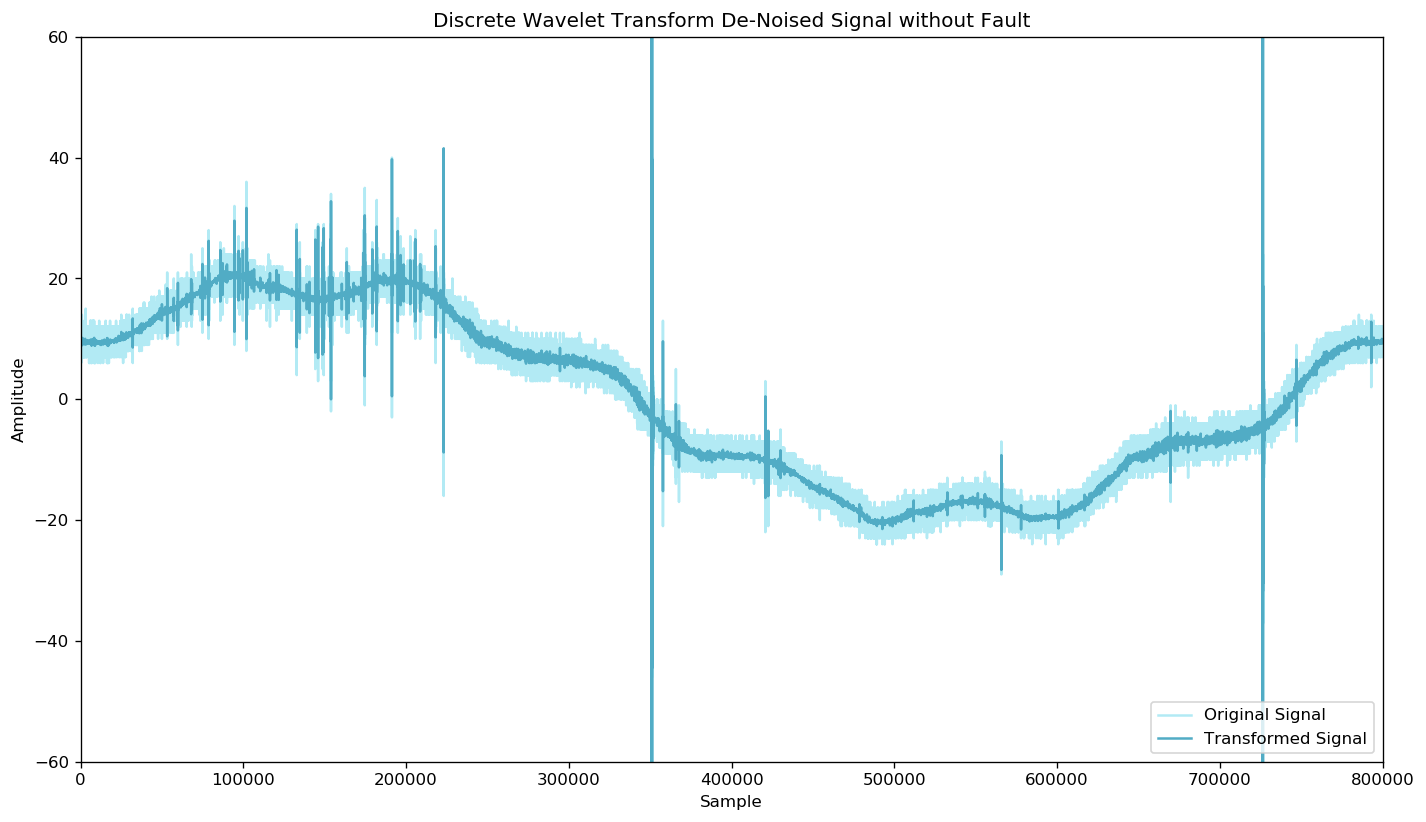

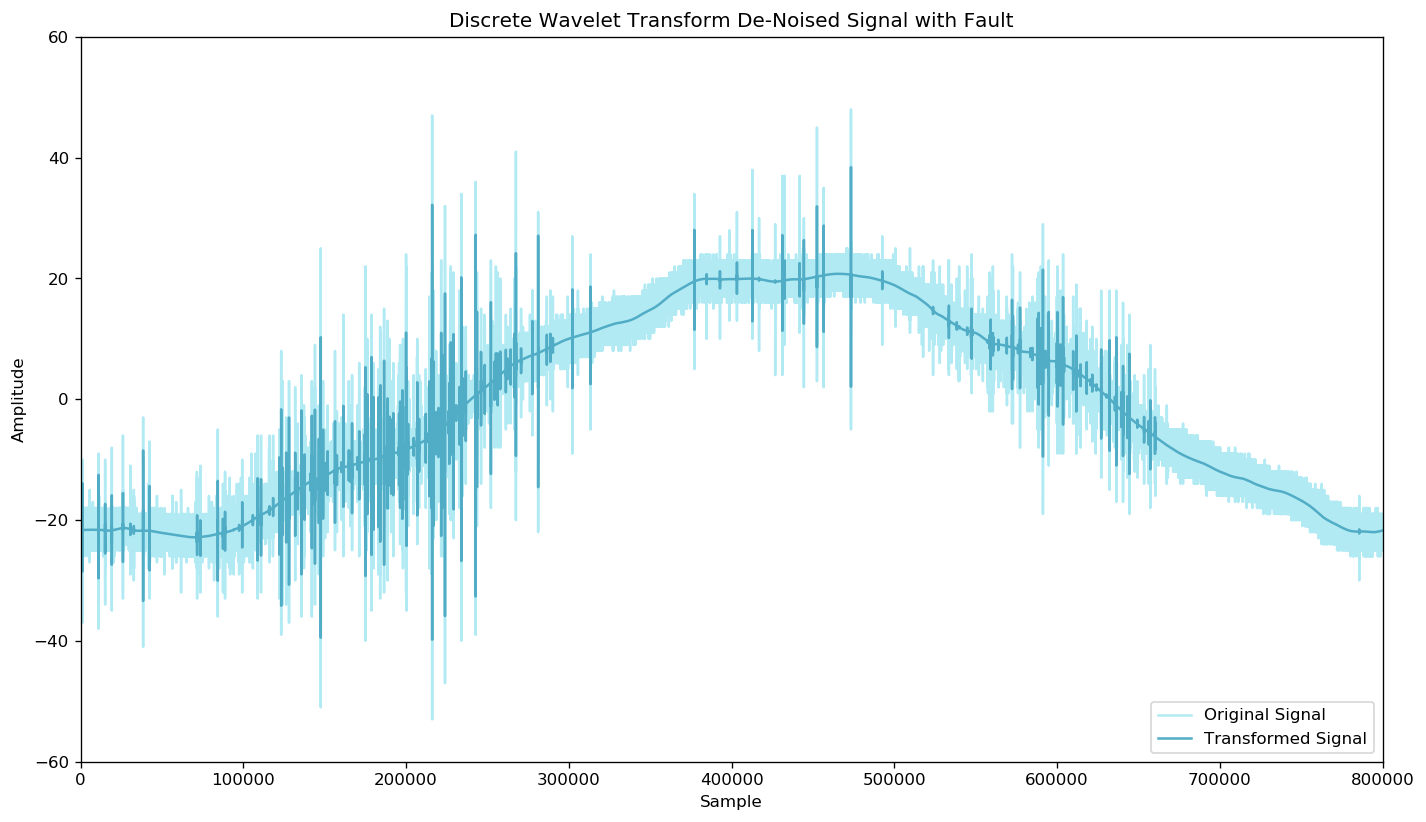

In [9]:
import pywt
from statsmodels.robust import mad
from scipy import signal
 
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color="#66D7EB", alpha=0.5, label="Original Signal")
    plt.plot( y, color="#51ACC5", label="Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))
    return y
title0 = 'Discrete Wavelet Transform De-Noised Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised Signal with Fault'
signal_0 =  waveletSmooth(subset_train["200"], wavelet="db4", level=1, title=title0 )
signal_1 =  waveletSmooth(subset_train["201"], wavelet="db4", level=1, title=title1 )

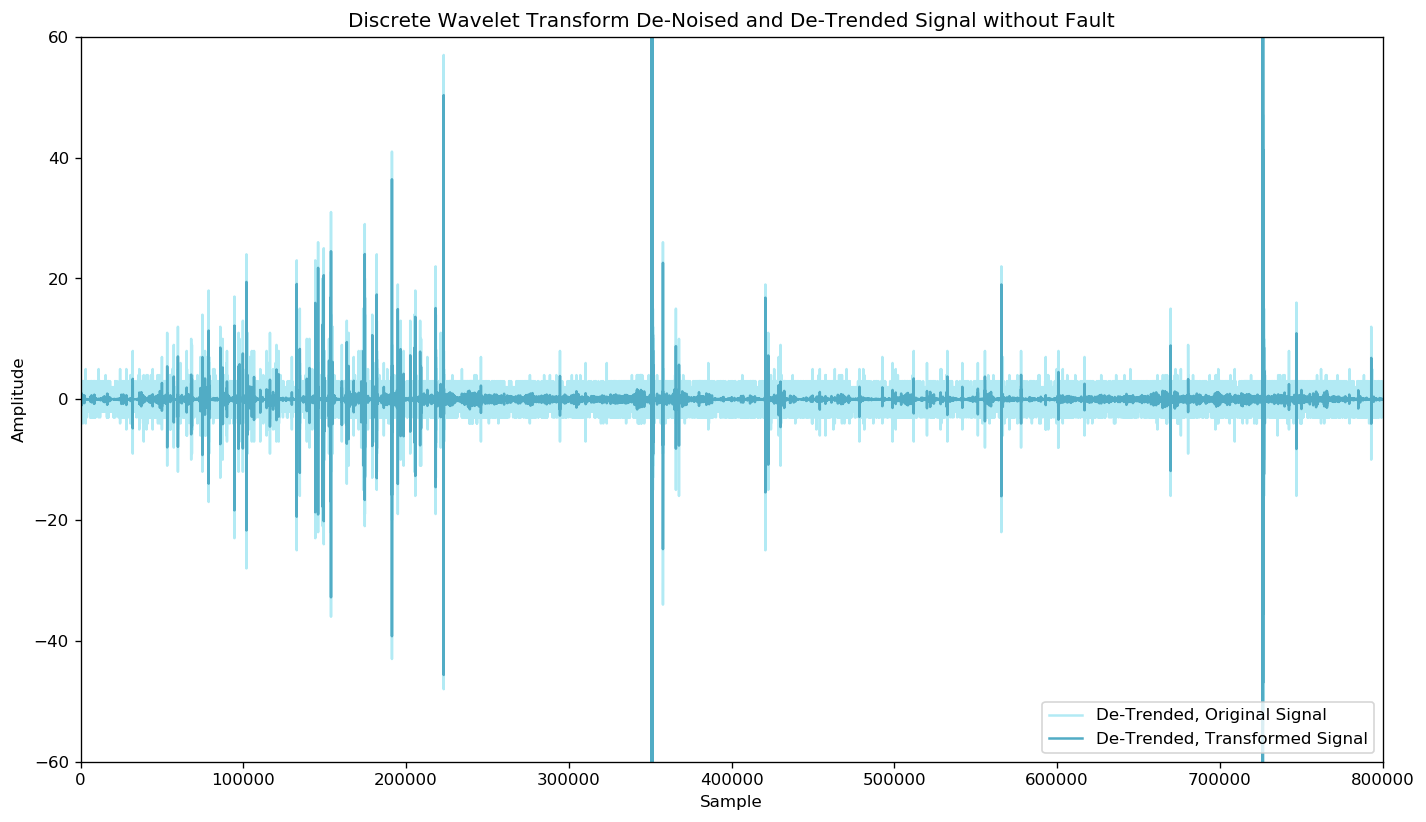

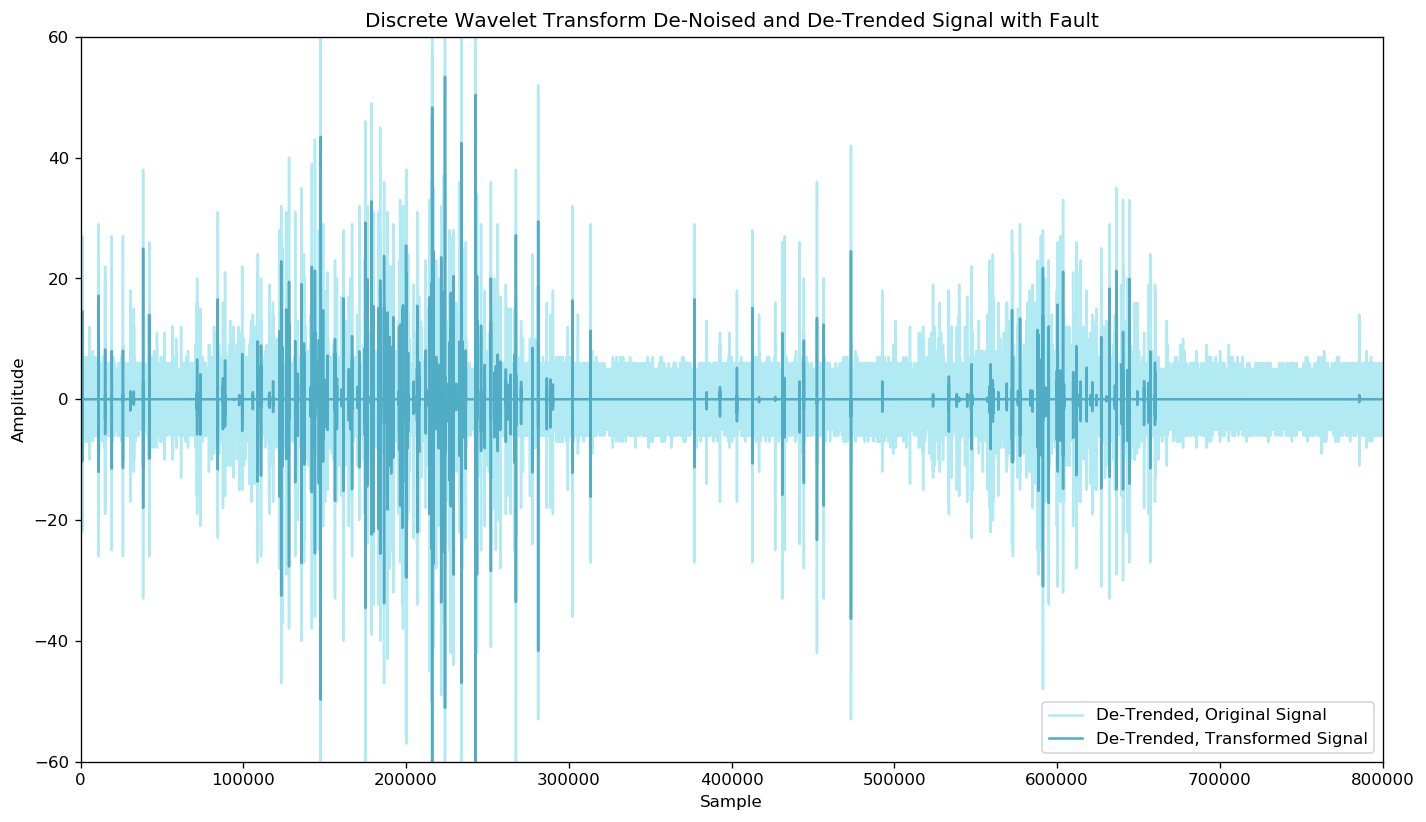

In [10]:
import pywt
from statsmodels.robust import mad
from scipy import signal
 
def waveletSmoothDetrend( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x.diff(), color="#66D7EB", alpha=0.5, label="De-Trended, Original Signal")
    plt.plot( np.diff(y, n=1), color="#51ACC5", label="De-Trended, Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))
    return np.diff(y, n=1)


title0 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal with Fault'
signal_0 =  waveletSmoothDetrend(subset_train["200"], wavelet="db4", level=1, title=title0 )
signal_1 =  waveletSmoothDetrend(subset_train["201"], wavelet="db4", level=1, title=title1 )

380
207


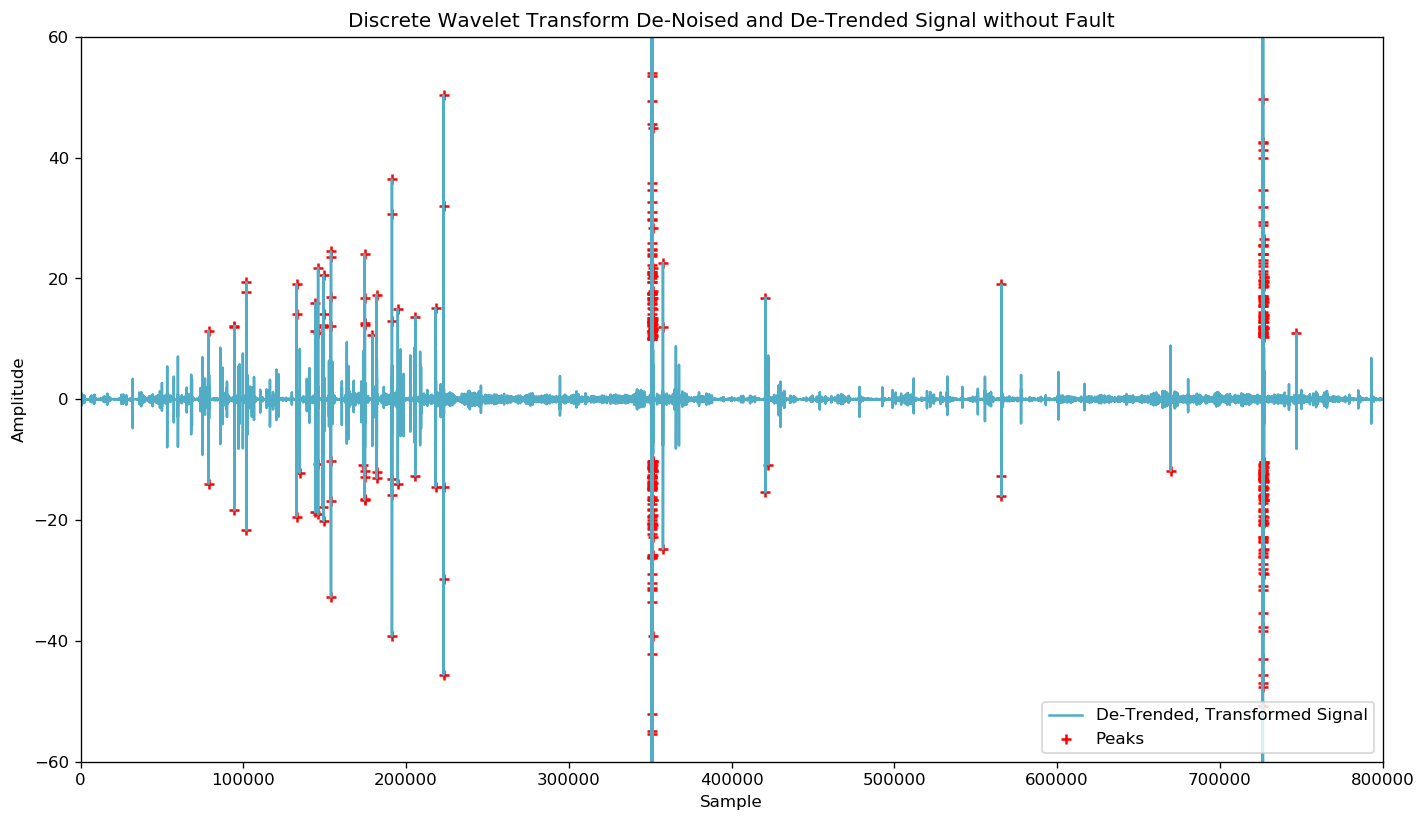

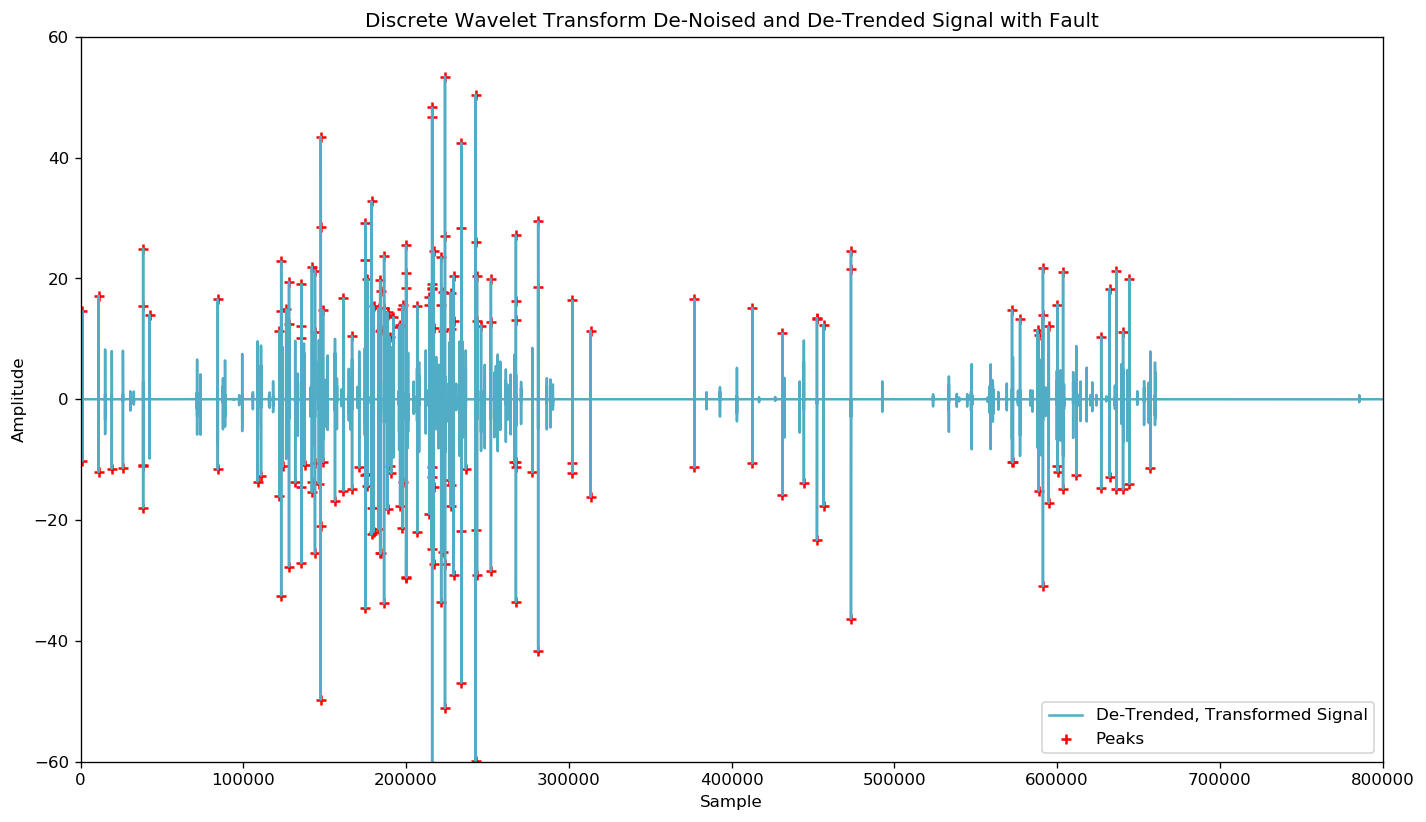

In [11]:
import peakutils

def find_peaks(signal, title):
    thresh = 0.7
    min_d = 1

    #peaks = peakutils.indexes(1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    peaks = np.argwhere(signal > 10).tolist()
    #valleys = peakutils.indexes(-1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    valleys = np.array(np.argwhere(signal < -10)).tolist()
    pois = np.sort(np.concatenate((peaks, valleys)))
    
    peak_indexes = []
    for pk in pois:
        peak_indexes.append(pk[0])

    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    #plt.plot( x.diff(), color="#66D7EB", alpha=0.5, label="De-Trended, Original Signal")
    plt.plot( signal, color="#51ACC5", label="De-Trended, Transformed Signal" )
    plt.scatter(peak_indexes, signal[peak_indexes], marker="+", color="red", label="Peaks" )
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((320700, 320800))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(signal)))
    print(len(peak_indexes))
    return peak_indexes

title0 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal with Fault'
peak_indexes0 = find_peaks(signal_0, title=title0 )
peak_indexes1 = find_peaks(signal_1, title=title1 )

In [12]:
def cancel_false_peaks(signal, peak_indexes):
    false_peak_indexes = []
    max_sym_distance = 10  #
    max_pulse_train = 500  # 
    max_height_ratio = 0.25  # 
    for pk in range(len(peak_indexes)-1):
        if not peak_indexes[pk] in false_peak_indexes:
            if (signal[peak_indexes[pk]] > 0 and signal[peak_indexes[pk+1]] < 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])

            if (signal[peak_indexes[pk]] < 0 and signal[peak_indexes[pk+1]] > 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
    return false_peak_indexes

false_peak_indexes0 = cancel_false_peaks(signal_0, peak_indexes0)
false_peak_indexes1 = cancel_false_peaks(signal_1, peak_indexes1)

In [20]:
def cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes):
    threshold = 60  # absolute value of for high amplitude peaks after DWT
    max_pulse_train = 500
    for pk_idx in peak_indexes:
        if not pk_idx in false_peak_indexes:
            if abs(signal[pk_idx]) > threshold:
                false_peak_indexes.append(pk_idx)
                scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
    return false_peak_indexes

false_peak_indexes0 = cancel_high_amp_peaks(signal_0, peak_indexes0, false_peak_indexes0)
false_peak_indexes1 = cancel_high_amp_peaks(signal_1, peak_indexes1, false_peak_indexes1)

In [21]:
# Calcel Peaks Flagged as False, Find True Preaks
def cancel_flagged_peaks(peak_indexes, false_peak_indexes):
    true_peak_indexes = list(set(peak_indexes) - set(false_peak_indexes))
    true_peak_indexes.sort()
    return true_peak_indexes

true_peak_indexes0 = cancel_flagged_peaks(peak_indexes0, false_peak_indexes0)
true_peak_indexes1 = cancel_flagged_peaks(peak_indexes1, false_peak_indexes1)

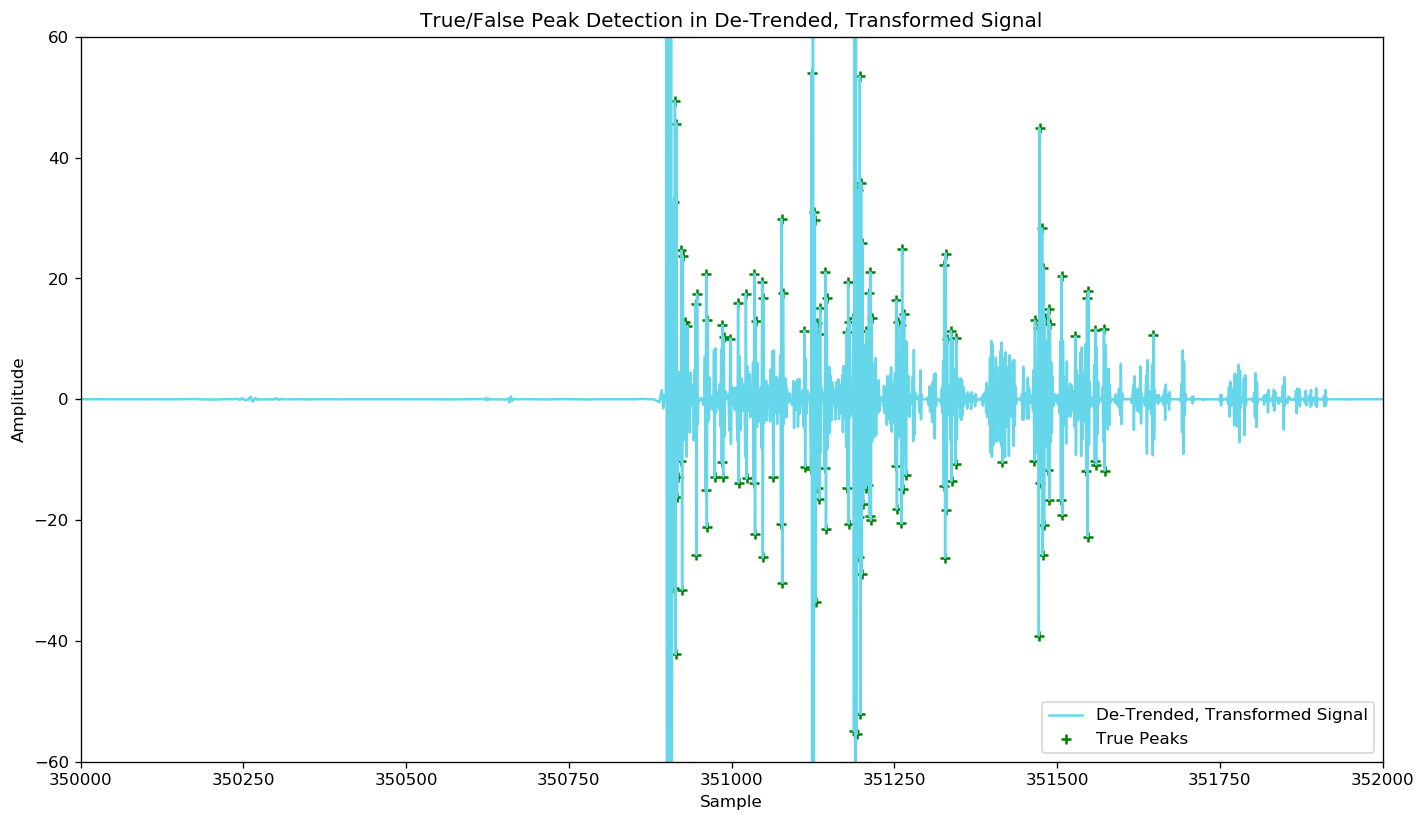

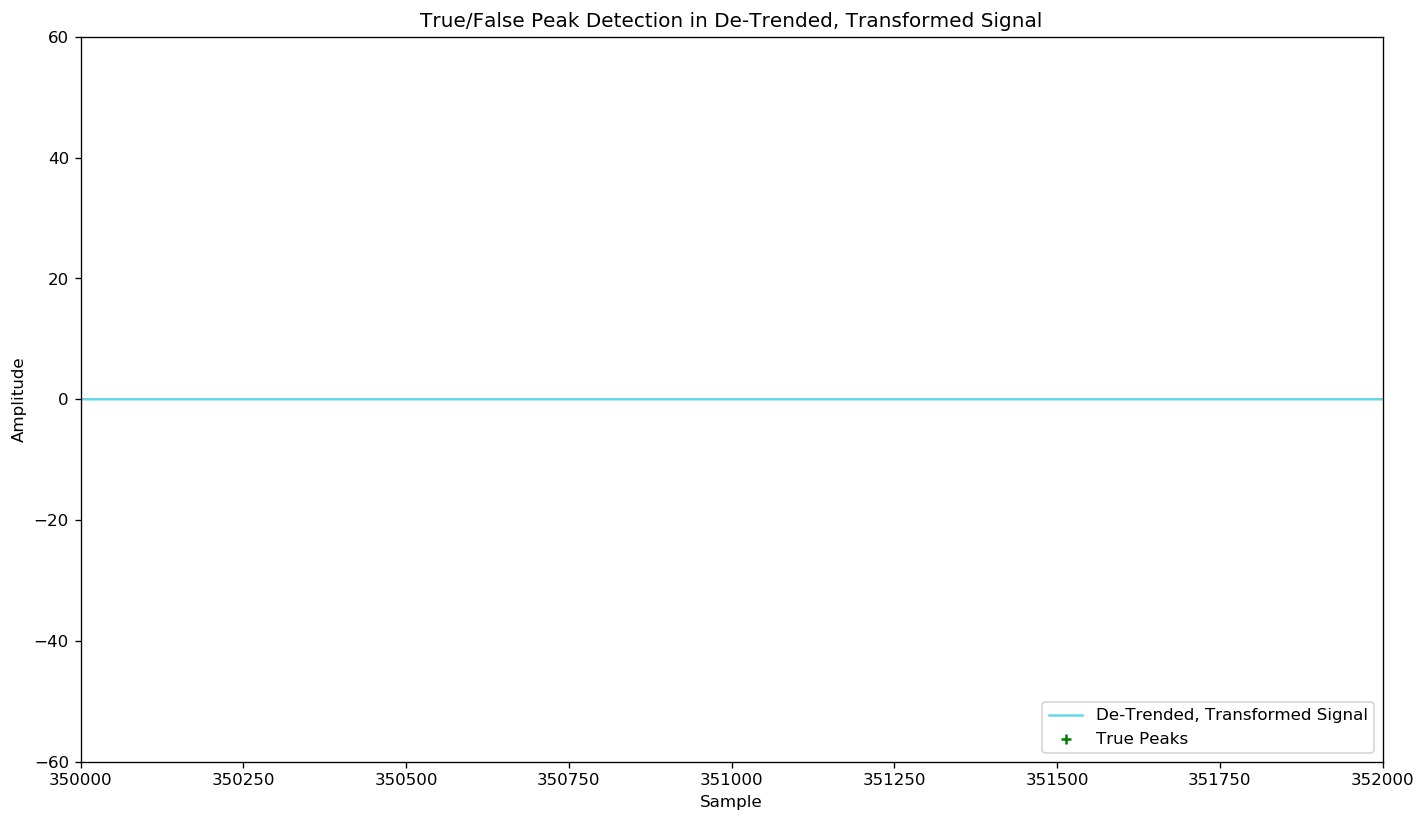

In [22]:
def plot_peaks(signal, true_peak_indexes, false_peak_indexes):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot( signal, color="#66D7EB", label="De-Trended, Transformed Signal" )  #5 alt color 1ACC5
    plt.scatter(true_peak_indexes, signal[true_peak_indexes], marker="+", color="green", label="True Peaks")
    #plt.scatter(false_peak_indexes, signal[false_peak_indexes], marker="x", color="red", label="False Peaks")
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((350000, 352000))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    title = "True/False Peak Detection in De-Trended, Transformed Signal"
    if title:
        ax.set_title(title)
    #ax.set_xlim((0,len(signal)))
    plt.show()
    return

plot_peaks(signal_0, true_peak_indexes0, false_peak_indexes0)
plot_peaks(signal_1, true_peak_indexes1, false_peak_indexes1)